In [1]:
import os
import numpy as np
import pandas as pd

from datetime import date, datetime

import financial.data as fd

from financial.io.cache import NoUpdateStrategy
from financial.io.file.cache import FileCache

today = date.today()

print("Today's date:", today)

start_year = 1980
end_year = 2023
    
start = datetime(start_year, 1, 1)
end = datetime(end_year, 12, 31) # today - datetime.timedelta(1) 
       
print("DATA @ "+os.environ["DATA"])
print("CACHE @ "+os.environ["CACHE"])
ds = fd.CachedDataStore(path=os.environ["DATA"], cache=FileCache(cache_path=os.environ["CACHE"]+"/", update_strategy=NoUpdateStrategy()))
    
start_index = str(start_year)+'-01-01' # '1990-01-01'
end_index = str(end_year)+'-12-31'     # '2020-12-31'
    

today = date.today()

print(f"Gold standard for {start_index} to {end_index}")
print(ds)

Today's date: 2024-10-08
DATA @ ..\acci-data-history
CACHE @ ..\acci-cache
Gold standard for 1980-01-01 to 2023-12-31
CachedDataStore with 946 data sources [cache stats: {'size': 0, 'hit': 0, 'miss': 0, 'write': 0, 'read': 0, 'update': 0}]


In [1]:
import tensorflow as tf

print(tf.__version__)

# List all physical devices of type GPU
gpus = tf.config.list_physical_devices('GPU')
print("GPUs Available: ", gpus)

2.16.1
GPUs Available:  []


## Data

In [2]:
ticker = '^GSPC' # 'GC=F'(gold)/'IAU'(SPDR)/'GLD'(iShares) 'GOVT'(iShares)/'ZB=F'/'ZN=F'(10-year) 'HYG' 'AGG' '^GSPC' '^NDX' '^NBI' '^IBEX' '^STOXX' '^STOXX50E'

data = ds.get_data(ticker,start_index, end_index)

print(data)

1980-01-01     107.900000
1980-01-02     105.760002
1980-01-03     105.220001
1980-01-04     106.519997
1980-01-07     106.809998
                 ...     
2023-12-22    4754.629883
2023-12-26    4774.750000
2023-12-27    4781.580078
2023-12-28    4783.350098
2023-12-29    4769.830078
Name: ^GSPC, Length: 11096, dtype: float64


# Model target: Risk

In [3]:
from financial.lab.trend.risk import *
from financial.lab.trend.trend import *

In [27]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rc('figure', figsize=(16, 9))
matplotlib.style.use('ggplot')

def risk_chart(data: pd.Series, risk: pd.Series):
    fig = plt.Figure()
    spec = matplotlib.gridspec.GridSpec(ncols=1, nrows=2, height_ratios=[4, 1])

    axis = fig.add_subplot(spec[0])
    axis.plot(data,'blue')

    axis = fig.add_subplot(spec[1])
    axis.set_ylim([-1.1,1.1])
    axis.set_xlabel("Date")    
    axis.set_ylabel("Risk")

    axis.plot(risk, label="Risk", color='red', alpha=1.0)
    return fig

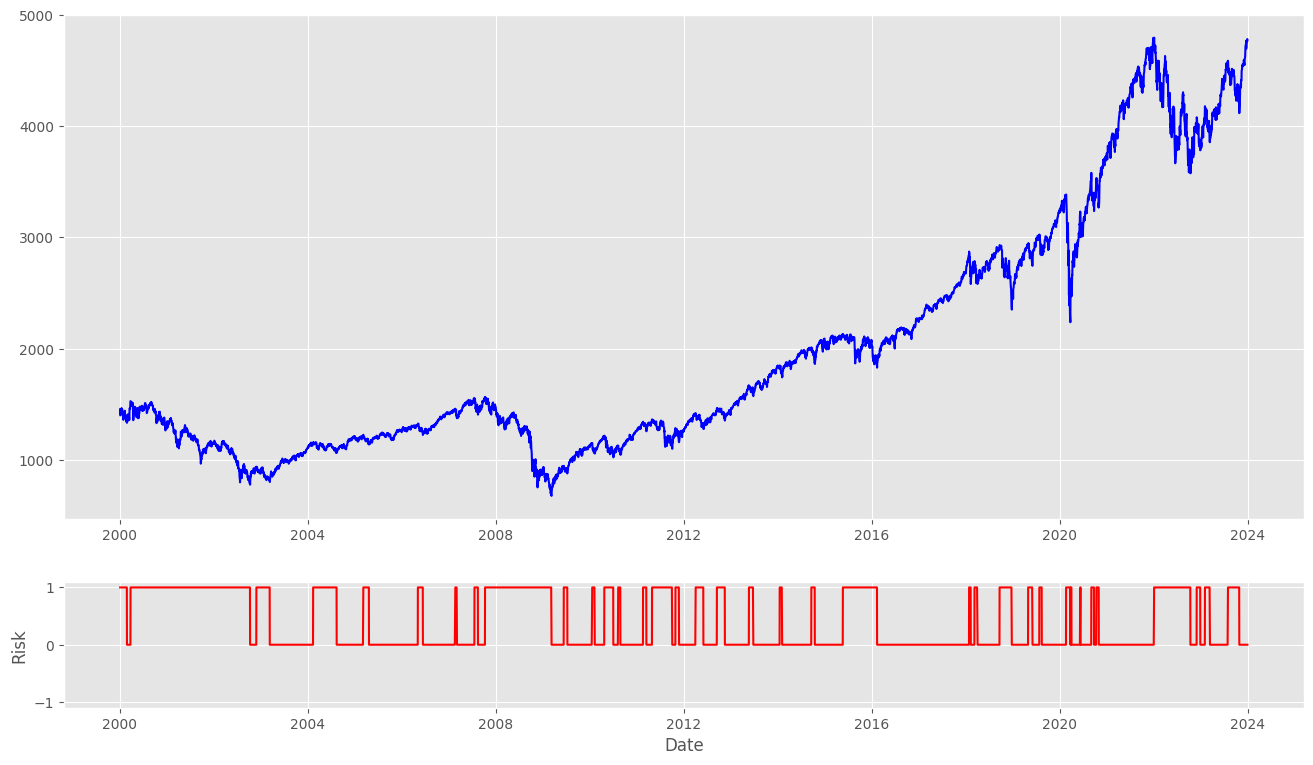

In [5]:
trends = TopKTrends( MaxDrawdownHorizon(1000), 64).trends(data)

risk = risk_from_trends(data, trends)
risk_chart(data['2000-01-01':],risk['2000-01-01':])

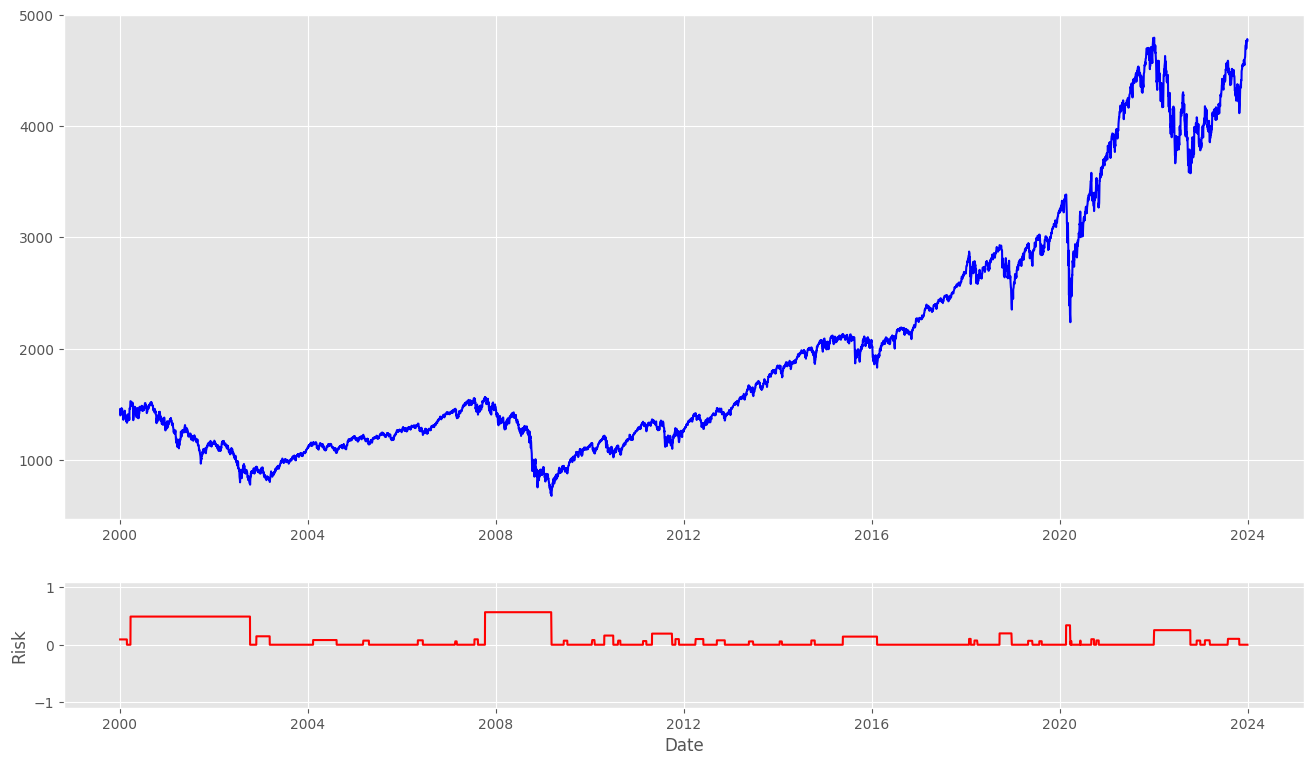

In [6]:
risk = overall_risk_from_trends(data, trends)
risk_chart(data['2000-01-01':],risk['2000-01-01':])

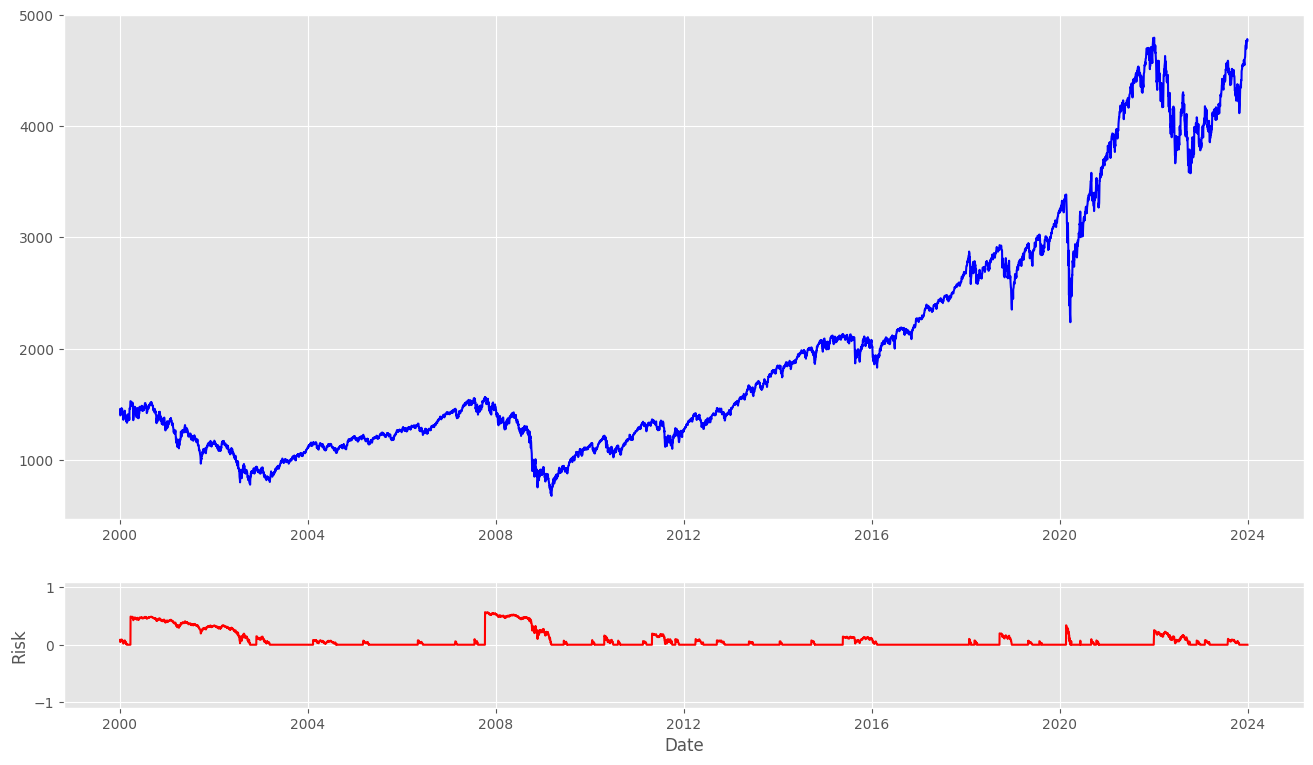

In [7]:
risk = expected_risk_from_trends(data, trends)
risk_chart(data['2000-01-01':],risk['2000-01-01':])

# RNNs

In [179]:
import keras

def rnn(timesteps:int, features: int, cells: int) -> keras.Model:
    inputs = keras.layers.Input(shape=(timesteps, features))
    lstm_out = keras.layers.SimpleRNN(cells)(inputs)
    outputs = keras.layers.Dense(1, activation='linear')(lstm_out)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

def lstm(timesteps:int, features: int, cells: int) -> keras.Model:
    inputs = keras.layers.Input(shape=(timesteps, features))
    lstm_out = keras.layers.LSTM(cells)(inputs)
    outputs = keras.layers.Dense(1, activation='linear')(lstm_out)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

def gru(timesteps:int, features: int, cells: int) -> keras.Model:
    inputs = keras.layers.Input(shape=(timesteps, features))
    lstm_out = keras.layers.GRU(cells)(inputs)
    outputs = keras.layers.Dense(1, activation='linear')(lstm_out)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


In [117]:
features = ['^GSPC', '^TNX']
timesteps = 60
cells = 8

In [180]:

rnn = rnn(timesteps,len(features),cells)
rnn.summary()

rnn_lstm = lstm(timesteps,len(features),cells)
rnn_lstm.summary()

rnn_gru = gru(timesteps,len(features),cells)
rnn_gru.summary()


Model: "functional_43"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_21 (InputLayer)          │ (None, 60, 2)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_7 (SimpleRNN)             │ (None, 8)                   │              88 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 97 (388.00 B)

 Trainable params: 97 (388.00 B)

 Non-trainable params: 0 (0.00 B)

Model: "functional_45"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_22 (InputLayer)          │ (None, 60, 2)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 8)                   │             352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 361 (1.41 KB)

 Trainable params: 361 (1.41 KB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_47"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_23 (InputLayer)          │ (None, 60, 2)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_7 (GRU)                          │ (None, 8)                   │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 297 (1.16 KB)

 Trainable params: 297 (1.16 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
    
def get_training_data(data: pd.DataFrame, target: str, timesteps: int):
    # reshape training data into [samples, timesteps, features]
    y = data[target].iloc[timesteps:]
    samples = len(y)
    features = len(data.columns)
    X = np.zeros((samples, timesteps, features))
    for index in range(samples):
        X[index] = data.iloc[index:index+timesteps,:]
    return X, y


dataset = pd.DataFrame()

for ticker in features:
    series = ds.get_data(ticker,start_index, end_index)
    
    dataset[ticker] = series

dataset = dataset.ffill()
dataset = dataset.dropna()

for ticker in features:
    dataset[ticker] = dataset[ticker].pct_change().dropna()

dataset = dataset.dropna()

print(dataset)

target = '^GSPC'
X, y = get_training_data(dataset, '^GSPC', timesteps)

print(dataset.shape)
#print(data)
print(X.shape)
#print(X)
print(y.shape)
#print(y)

print(X[0])
print(y.iloc[0])
print(dataset[target].iloc[timesteps])

print(X[-1])
print(y.iloc[-1])
print(dataset[target].iloc[-1])

               ^GSPC      ^TNX
1980-01-03 -0.005106  0.009524
1980-01-04  0.012355  0.005660
1980-01-07  0.002723 -0.002814
1980-01-08  0.020036 -0.005644
1980-01-09  0.000918  0.000946
...              ...       ...
2023-12-22  0.001660  0.001798
2023-12-26  0.004232 -0.003845
2023-12-27  0.001430 -0.024961
2023-12-28  0.000370  0.016099
2023-12-29 -0.002826  0.004156

[11094 rows x 2 columns]
(11094, 2)
(11034, 60, 2)
(11034,)
[[-5.10590870e-03  9.52384585e-03]
 [ 1.23550219e-02  5.66032677e-03]
 [ 2.72250211e-03 -2.81423390e-03]
 [ 2.00355719e-02 -5.64444205e-03]
 [ 9.17908273e-04  9.46095475e-04]
 [ 7.70285479e-03 -6.61622829e-03]
 [ 2.72989166e-04  1.61750783e-02]
 [ 4.18485346e-03  1.87261269e-03]
 [ 6.88532483e-03 -4.67291511e-03]
 [-8.09756509e-04  0.00000000e+00]
 [-3.15178833e-03  5.63384242e-03]
 [ 3.34239166e-03  1.02707429e-02]
 [ 9.27342020e-03  1.29390339e-02]
 [-5.26312530e-03 -1.00364650e-02]
 [ 1.73078672e-02 -2.76504015e-03]
 [ 2.29191203e-03  1.75601238e-02]
 [-7.91

In [206]:

rnn_gru.compile(loss='mean_squared_error', optimizer='adam')
rnn_gru.fit(X, y, epochs=10, batch_size=256)


Epoch 1/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.4380e-04
Epoch 2/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.2120e-04
Epoch 3/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.2113e-04
Epoch 4/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1.3196e-04
Epoch 5/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.2704e-04
Epoch 6/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.2996e-04
Epoch 7/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.2957e-04
Epoch 8/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.2812e-04
Epoch 9/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.2194e-04
Epoch 10/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.2856e-04


In [13]:
samples = len(y) # 100 # len(y)

#X_test = []
#for i in range(samples):
#    X_test.append(changes.iloc[i:i+timesteps])

X_test = X

print(X_test.shape)

(11034, 60, 2)


In [14]:
def forecast(model, Xtest):
    yhat = model.predict(Xtest)
    return yhat

In [208]:
yhat = forecast(rnn_gru, X_test)
print(yhat.size)
yhat = pd.Series(yhat.reshape(yhat.size), index=y.index)
print(yhat.size)

345/345 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
11034
11034


Test RMSE: 0.011


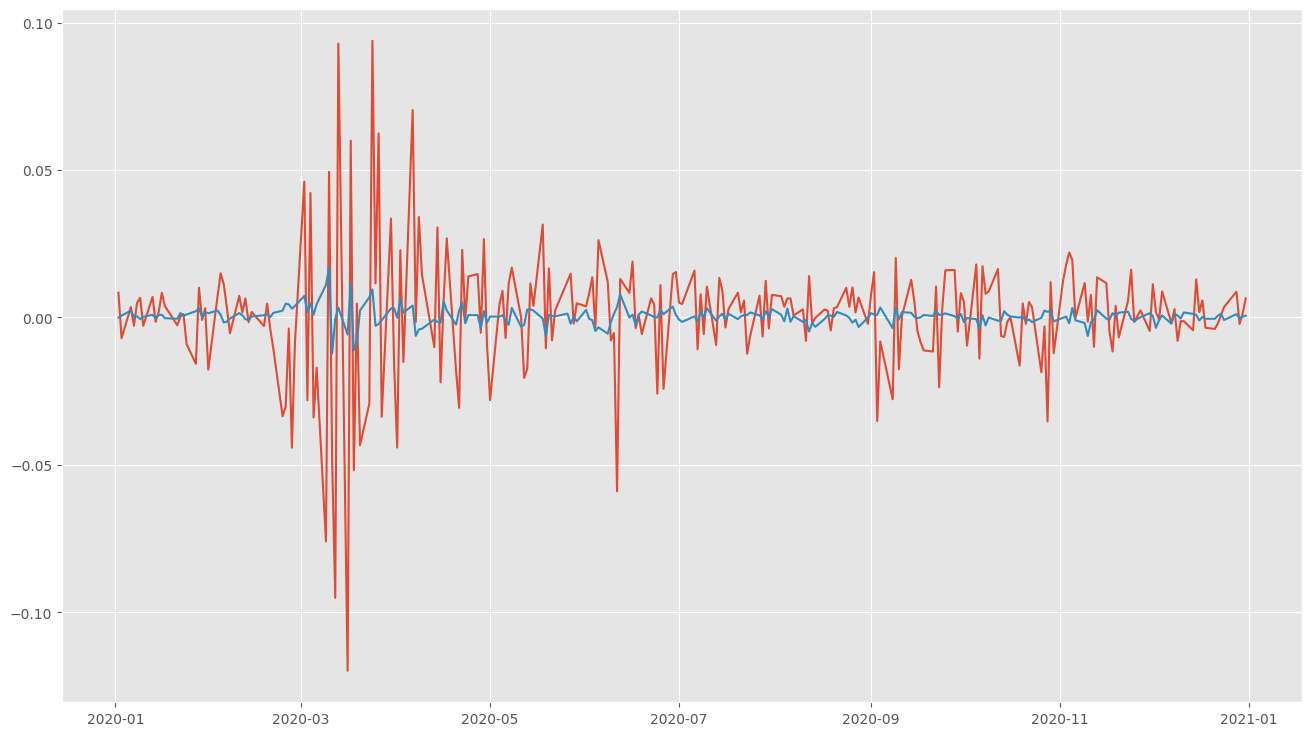

In [209]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y[:samples], yhat))
print('Test RMSE: %.3f' % rmse)


# line plot of observed vs predicted
from matplotlib import pyplot
pyplot.plot(y['2020-01-01':'2021-01-01'])
pyplot.plot(yhat['2020-01-01':'2021-01-01'])
pyplot.show()

In [210]:
initial_value = data.iloc[0]
y_restored = initial_value*(y + 1).cumprod()
yhat_restored = initial_value*(yhat + 1).cumprod()
yhat_running = data.shift(1)*(1+yhat)
#print(data.shift(1))
#print(yhat)
#print(yhat.size)
#print(yhat_running)
#print(yhat_running.size)


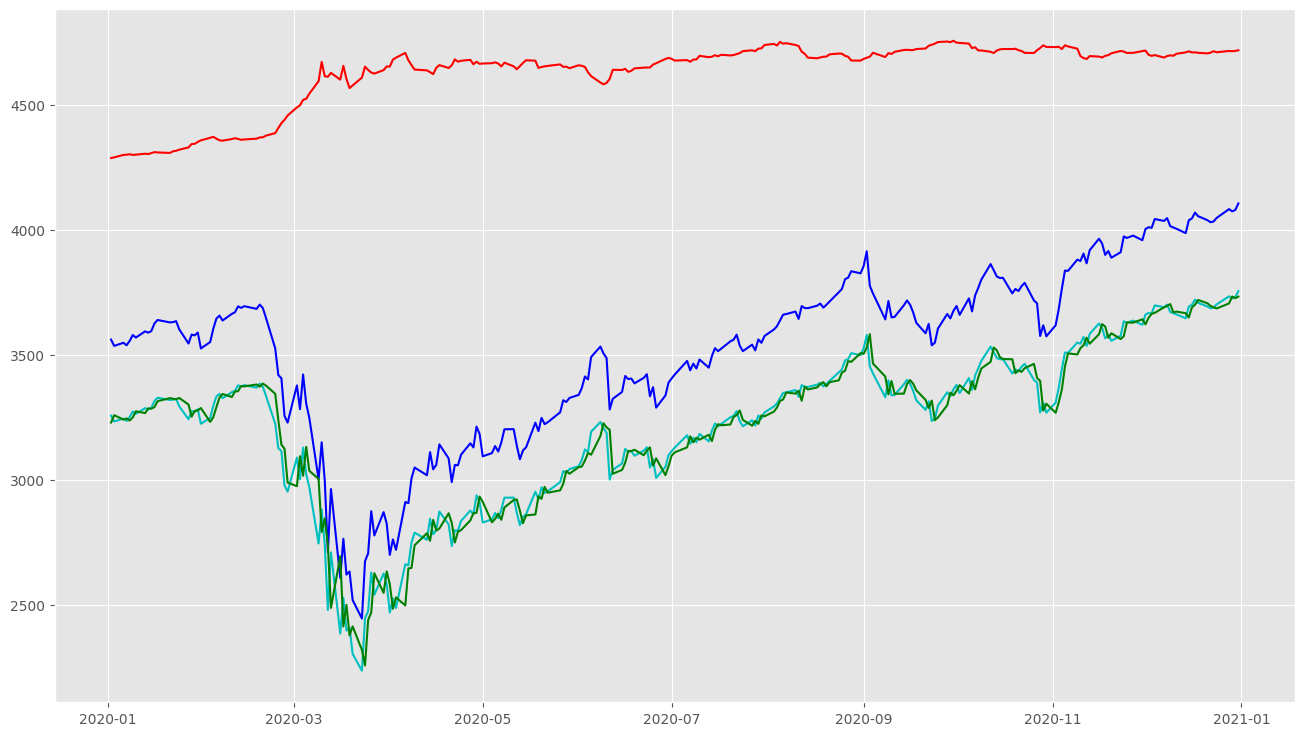

In [211]:
from matplotlib import pyplot
pyplot.plot(data['2020'], 'c')
pyplot.plot(y_restored['2020'], 'b')
pyplot.plot(yhat_restored['2020'], 'r')
pyplot.plot(yhat_running['2020'], 'g')
pyplot.show()

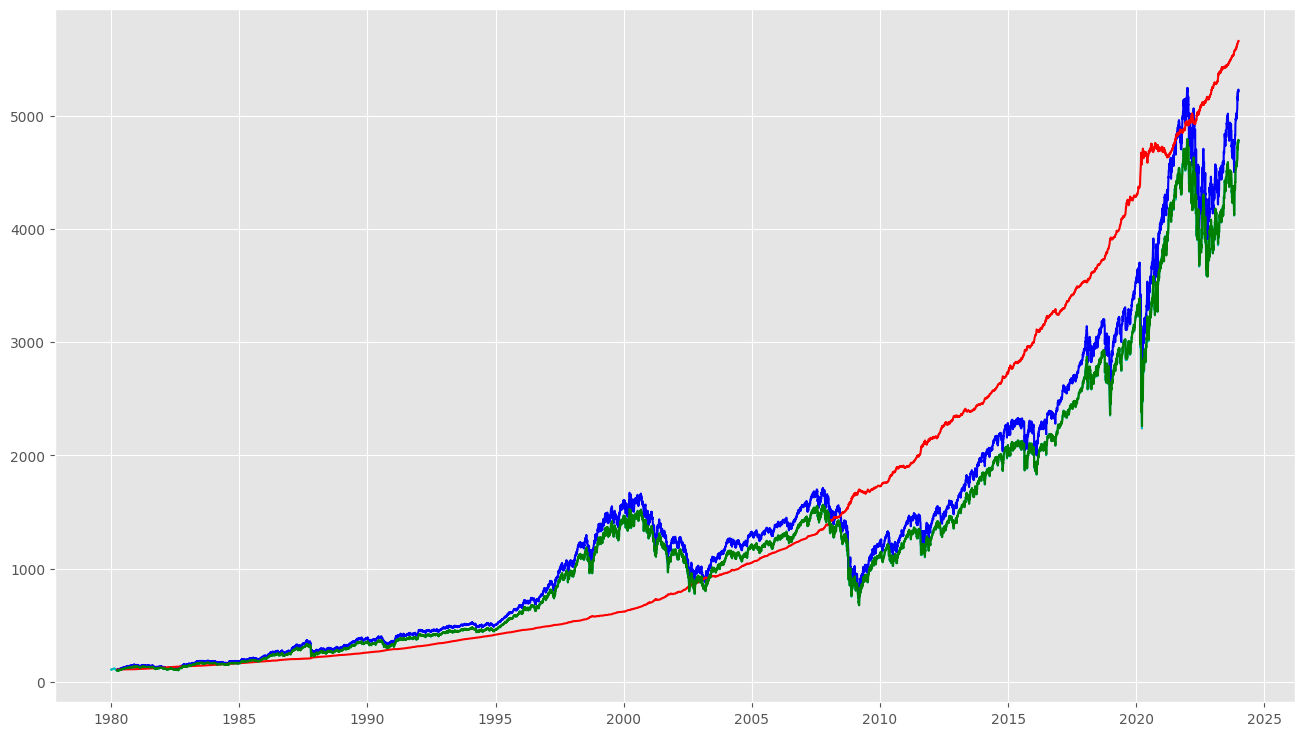

In [212]:
from matplotlib import pyplot
pyplot.plot(data, 'c')
pyplot.plot(y_restored, 'b')
pyplot.plot(yhat_restored, 'r')
pyplot.plot(yhat_running, 'g')
pyplot.show()

# CNN

In [69]:
import keras

def cnn_2d(timesteps=60, features=82, filters=(8,8,8), dropout_rate=0.1):
    '''
    2D-CNNpred model according to the paper 
    "CNNpred: CNN-based stock market prediction using a diverse set of variables” 
    '''
    model = keras.Sequential([
        keras.layers.Input(shape=(timesteps, features)),
        keras.layers.Conv2D(filters[0], kernel_size=(1, features), activation="relu"),
        keras.layers.Conv2D(filters[1], kernel_size=(3,1), activation="relu"),
        keras.layers.MaxPool2D(pool_size=(2,1)),
        keras.layers.Conv2D(filters[2], kernel_size=(3,1), activation="relu"),
        keras.layers.MaxPool2D(pool_size=(2,1)),
        keras.layers.Flatten(),
        keras.layers.Dropout(dropout_rate),
        keras.layers.Dense(1, activation="sigmoid")
    ])
    return model

def cnn_1d(timesteps=60, features=82, filters=(8,8,8) ):
    input_layer = keras.layers.Input(shape=(timesteps,features))

    conv1 = keras.layers.Conv1D(filters=filters[0], kernel_size=features*timesteps, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)

    conv2 = keras.layers.Conv1D(filters=filters[1], kernel_size=3, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)

    conv3 = keras.layers.Conv1D(filters=filters[2], kernel_size=3, padding="same")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)

    gap = keras.layers.GlobalAveragePooling1D()(conv3)

    output_layer = keras.layers.Dense(1, activation="linear")(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)


In [70]:
cnn = cnnpred_2d(timesteps,len(features))
cnn.summary()

cnn1 = cnn_1d(timesteps,len(features))
cnn1.summary()


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_48 (Conv2D)                   │ (None, 60, 1, 8)            │              24 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_49 (Conv2D)                   │ (None, 58, 1, 8)            │             200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_32 (MaxPooling2D)      │ (None, 29, 1, 8)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_50 (Conv2D)                   │ (None, 27, 1, 8)            │             200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_33 (MaxPooling2D)      │ (None, 13, 1, 8)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_19 (Flatten)                 │ (None, 104)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 104)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 1)                   │             105 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 529 (2.07 KB)

 Trainable params: 529 (2.07 KB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_30 (InputLayer)          │ (None, 60, 2)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_11 (Conv1D)                   │ (None, 60, 8)               │           1,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 60, 8)               │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_6 (ReLU)                       │ (None, 60, 8)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_12 (Conv1D)                   │ (None, 60, 8)               │             200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 60, 8)               │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_7 (ReLU)                       │ (None, 60, 8)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_13 (Conv1D)                   │ (None, 60, 8)               │             200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 60, 8)               │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_8 (ReLU)                       │ (None, 60, 8)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_2           │ (None, 8)                   │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,433 (9.50 KB)

 Trainable params: 2,385 (9.32 KB)

 Non-trainable params: 48 (192.00 B)

In [210]:
cnn.compile(loss='mean_squared_error', optimizer='adam')
cnn.fit(X, y, epochs=10, batch_size=256)

#cnn1.compile(loss='mean_squared_error', optimizer='adam')
#cnn1.fit(X, y, epochs=5, batch_size=256)


Epoch 1/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.3169e-04
Epoch 2/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2999e-04
Epoch 3/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.3516e-04
Epoch 4/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2831e-04
Epoch 5/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2780e-04
Epoch 6/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2221e-04
Epoch 7/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2646e-04
Epoch 8/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2799e-04
Epoch 9/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2699e-04
Epoch 10/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2473e-04


In [211]:
yhat = forecast(cnn, X_test)
print(yhat.size)
yhat = pd.Series(yhat.reshape(yhat.size), index=y.index)
print(yhat.size)

345/345 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
11034
11034


Test RMSE: 0.011


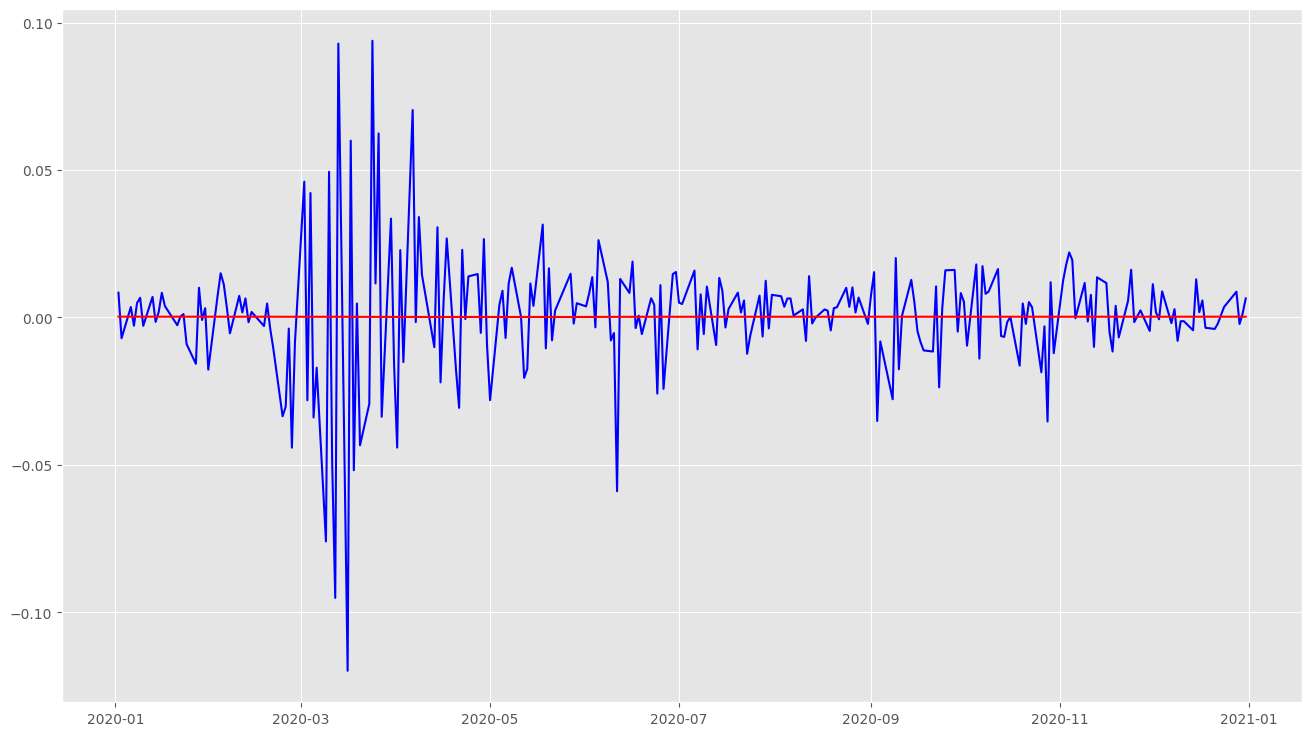

In [212]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y[:samples], yhat))
print('Test RMSE: %.3f' % rmse)


# line plot of observed vs predicted
from matplotlib import pyplot
pyplot.plot(y['2020-01-01':'2021-01-01'], 'b')
pyplot.plot(yhat['2020-01-01':'2021-01-01'], 'r')
pyplot.show()

In [213]:
initial_value = data.iloc[0]
y_restored = initial_value*(y + 1).cumprod()
yhat_restored = initial_value*(yhat + 1).cumprod()
yhat_running = data.shift(1)*(1+yhat)


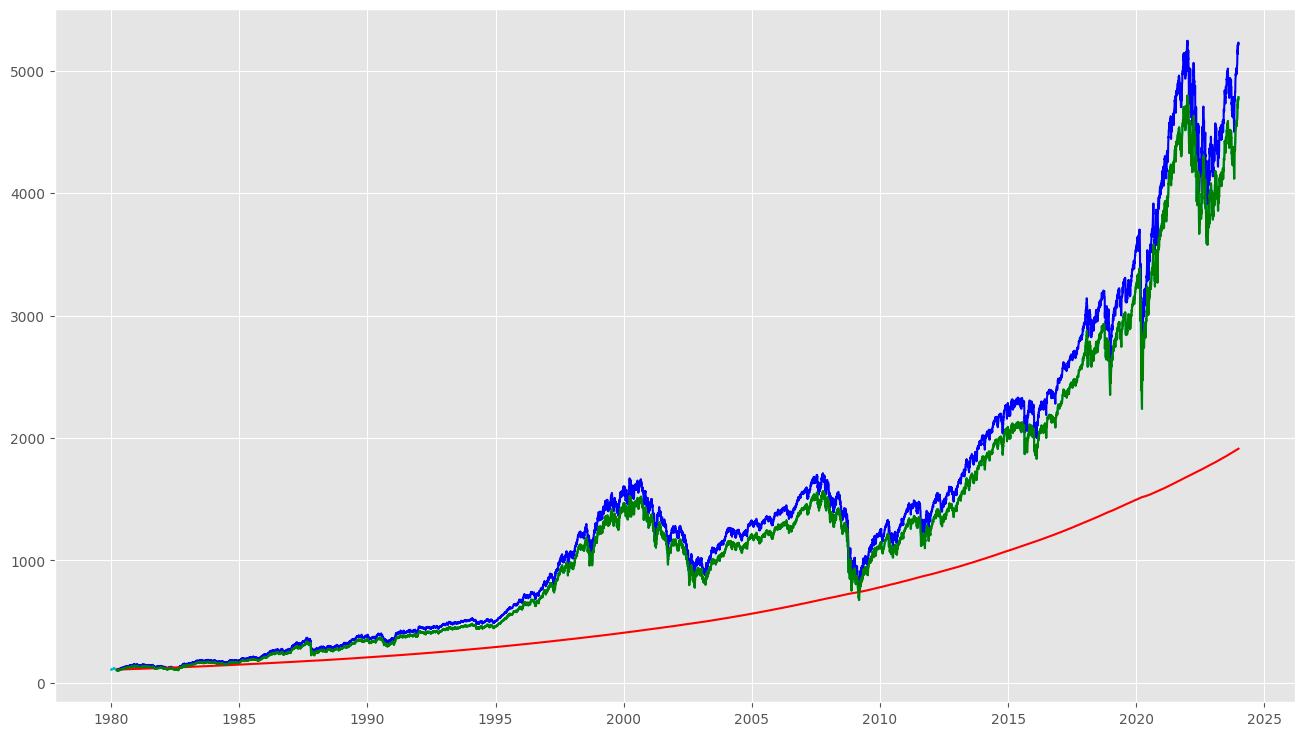

In [214]:
from matplotlib import pyplot
pyplot.plot(data, 'c')
pyplot.plot(y_restored, 'b')
pyplot.plot(yhat_restored, 'r')
pyplot.plot(yhat_running, 'g')
pyplot.show()

# Transformer

In [125]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Attention and Normalization
    x = keras.layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    x = keras.layers.Dropout(dropout)(x)
    x = keras.layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs
    # Feed Forward Part
    x = keras.layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(res)
    x = keras.layers.Dropout(dropout)(x)
    x = keras.layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    x = keras.layers.LayerNormalization(epsilon=1e-6)(x)
    return x + res

def transformer_model(
    timesteps: int=60, features: int=82,
    head_size = 4,
    num_heads = 3,
    ff_dim = 8,
    num_transformer_blocks = 2,
    mlp_units: list[int] = [16],
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.layers.Input(shape=(timesteps,features))
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = keras.layers.GlobalAveragePooling1D(data_format="channels_last")(x)
    for dim in mlp_units:
        x = keras.layers.Dense(dim, activation="relu")(x)
        x = keras.layers.Dropout(mlp_dropout)(x)
    outputs = keras.layers.Dense(1, activation="linear")(x)
    return keras.Model(inputs, outputs)


In [132]:
transformer = transformer_model(timesteps, len(features))
transformer.summary()

Model: "functional_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_39 (InputLayer)   │ (None, 60, 2)             │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ multi_head_attention_8        │ (None, 60, 2)             │             134 │ input_layer_39[0][0],      │
│ (MultiHeadAttention)          │                           │                 │ input_layer_39[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_43 (Dropout)          │ (None, 60, 2)             │               0 │ multi_head_attention_8[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization_16        │ (None, 60, 2)             │               4 │ dropout_43[0][0]           │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_16 (Add)                  │ (None, 60, 2)             │               0 │ layer_normalization_16[0]… │
│                               │                           │                 │ input_layer_39[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_30 (Conv1D)            │ (None, 60, 8)             │              24 │ add_16[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_44 (Dropout)          │ (None, 60, 8)             │               0 │ conv1d_30[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_31 (Conv1D)            │ (None, 60, 2)             │              18 │ dropout_44[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization_17        │ (None, 60, 2)             │               4 │ conv1d_31[0][0]            │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_17 (Add)                  │ (None, 60, 2)             │               0 │ layer_normalization_17[0]… │
│                               │                           │                 │ add_16[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ multi_head_attention_9        │ (None, 60, 2)             │             134 │ add_17[0][0], add_17[0][0] │
│ (MultiHeadAttention)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_46 (Dropout)          │ (None, 60, 2)             │               0 │ multi_head_attention_9[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization_18        │ (None, 60, 2)             │               4 │ dropout_46[0][0]           │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_18 (Add)                  │ (None, 60, 2)             │               

 Total params: 433 (1.69 KB)

 Trainable params: 433 (1.69 KB)

 Non-trainable params: 0 (0.00 B)

In [175]:
transformer.compile(loss='mean_squared_error', optimizer='adam')
transformer.fit(X, y, epochs=20, batch_size=512)


Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - loss: 3.4618e-04
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 1.6151e-04
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 1.3125e-04
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 1.3973e-04
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 1.3452e-04
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 1.2528e-04
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 1.4075e-04
Epoch 8/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 1.3083e-04
Epoch 9/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 1.2913e-04
Epoch 10/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 1.2865e-04
Epoch 11/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 1.2880e-04
Epoch 12/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 1.2744e-04
Epoch 13/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 1.2914e-04
Epoch 14/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 1.2131e-04
Epoch 15/20
22/

In [176]:
yhat = forecast(transformer, X_test)
print(yhat.size)
yhat = pd.Series(yhat.reshape(yhat.size), index=y.index)
print(yhat.size)

345/345 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
11034
11034


Test RMSE: 0.011


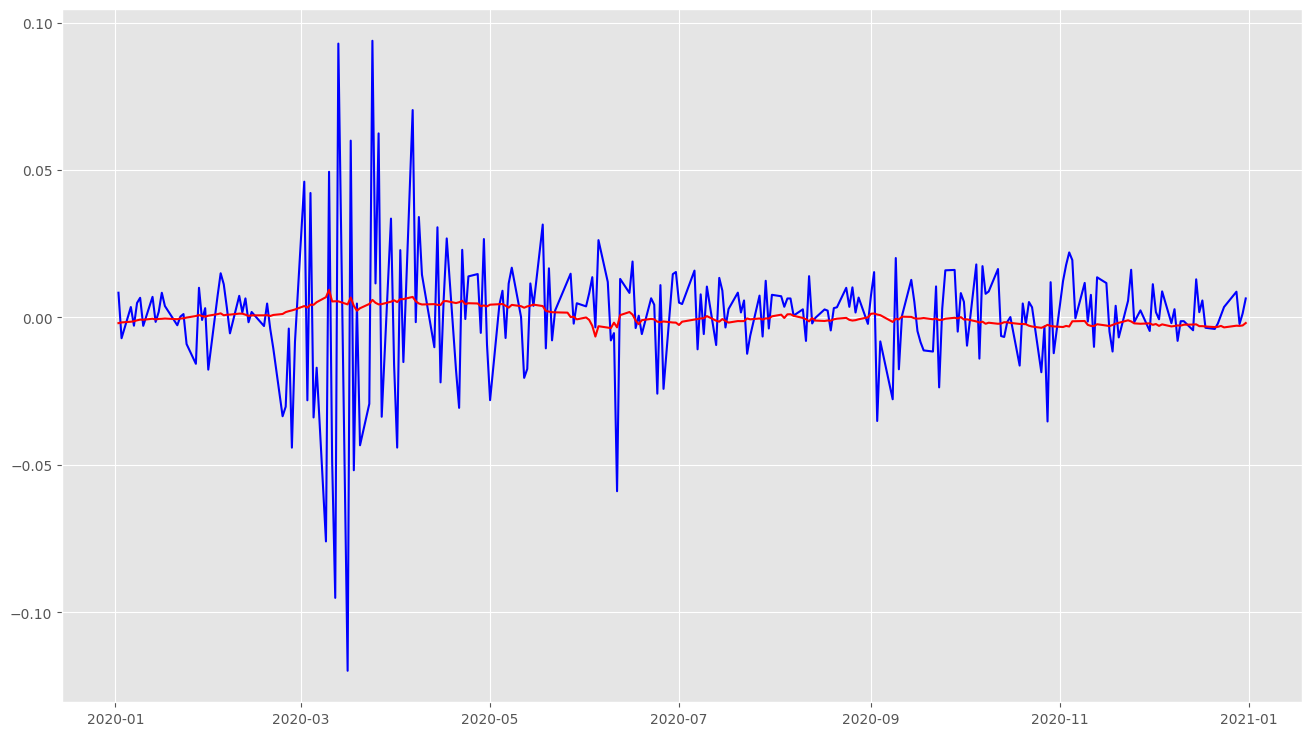

In [177]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y[:samples], yhat))
print('Test RMSE: %.3f' % rmse)


# line plot of observed vs predicted
from matplotlib import pyplot
pyplot.plot(y['2020-01-01':'2021-01-01'], 'b')
pyplot.plot(yhat['2020-01-01':'2021-01-01'], 'r')
pyplot.show()

In [178]:
initial_value = data.iloc[0]
y_restored = initial_value*(y + 1).cumprod()
yhat_restored = initial_value*(yhat + 1).cumprod()
yhat_running = data.shift(1)*(1+yhat)

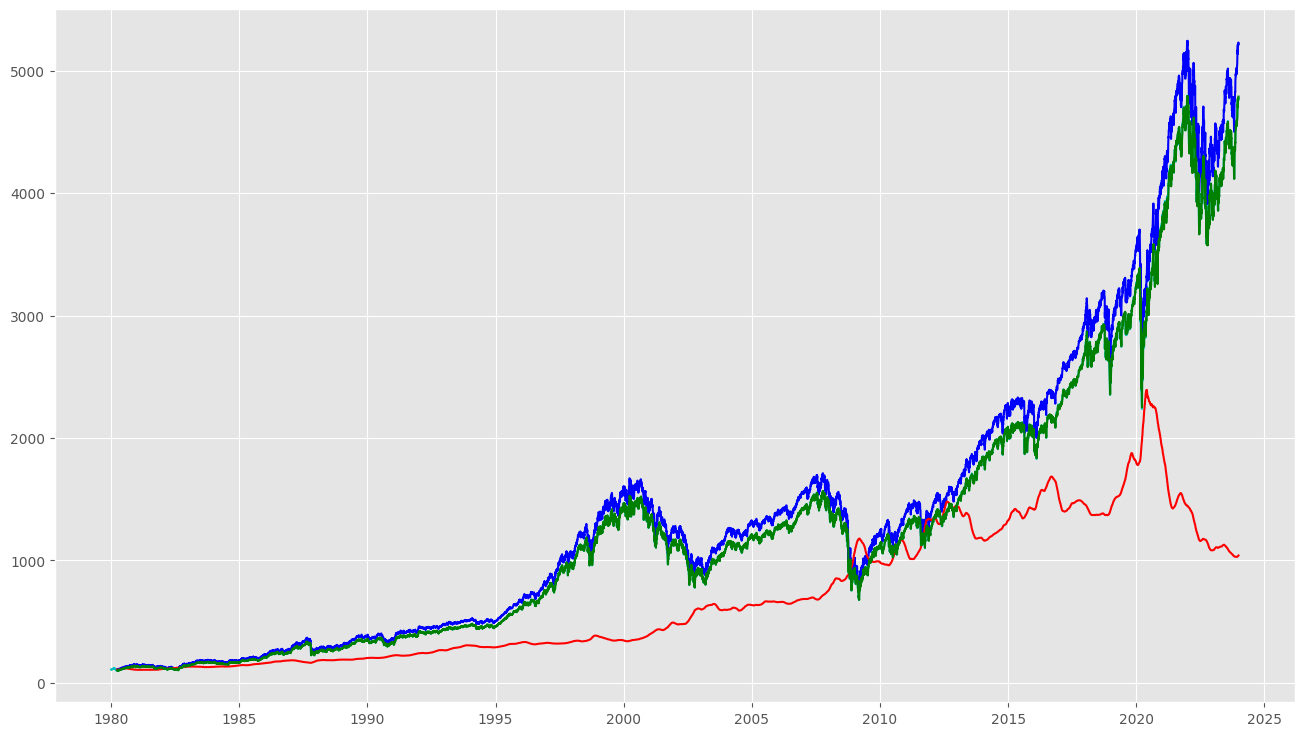

In [179]:
from matplotlib import pyplot
pyplot.plot(data, 'c')
pyplot.plot(y_restored, 'b')
pyplot.plot(yhat_restored, 'r')
pyplot.plot(yhat_running, 'g')
pyplot.show()